In [9]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [13]:
import kagglehub
import os

# Download dataset
path = kagglehub.dataset_download("farzadnekouei/trash-type-image-dataset")
print("Root path:", path)

# Correct path to actual dataset folder
dataset_path = os.path.join(path, "TrashType_Image_Dataset")
print("Dataset path:", dataset_path)

# Verify folder exists
if not os.path.exists(dataset_path):
    print("ERROR: Dataset folder not found at", dataset_path)
    print("Contents of root:", os.listdir(path))
else:
    classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

    for cls in classes:
        class_folder = os.path.join(dataset_path, cls)

        if os.path.exists(class_folder):
            count = len(os.listdir(class_folder))
            print(f"{cls}: {count} images")
        else:
            print(f"WARNING: Class folder not found - {class_folder}")


Root path: /kaggle/input/trash-type-image-dataset
Dataset path: /kaggle/input/trash-type-image-dataset/TrashType_Image_Dataset
cardboard: 403 images
glass: 501 images
metal: 410 images
paper: 594 images
plastic: 482 images
trash: 137 images


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [ ]:
# 1. Data Augmentation & Preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.25,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest',
    validation_split=0.15
)

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 2150 images belonging to 6 classes.
Found 377 images belonging to 6 classes.


In [ ]:
# 2. Compute class weights (for imbalanced classes)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))


In [ ]:
save_path = '/content/drive/My Drive/waste_classifier_resnet50.keras'

In [ ]:
# 3. Model Architecture
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3), alpha=1.0)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)


In [ ]:
# 4. Freeze base model
for layer in base_model.layers:
    layer.trainable = False

# 5. Compile
optimizer = Adam(learning_rate=5e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# 6. Callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6),
    ModelCheckpoint('/content/drive/My Drive/waste_classifier_best.keras', save_best_only=True, monitor='val_accuracy')
]

In [ ]:
import tensorflow as tf

class SaveBestTrainVal(tf.keras.callbacks.Callback):
    def __init__(self, path): super().__init__(); self.path = path; self.best = (-1, -1)
    def on_epoch_end(self, e, logs={}):
        acc, val_acc = logs.get('accuracy'), logs.get('val_accuracy')
        if acc > self.best[0] and val_acc > self.best[1]:
            self.best = (acc, val_acc)
            self.model.save(self.path)
            print(f"\nSaved best model: train_acc={acc:.4f}, val_acc={val_acc:.4f}")

# Usage:
callbacks = [
    SaveBestTrainVal('/content/drive/My Drive/waste_classifier_best_train_val.keras')
]

In [ ]:
# 7. Initial Training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,  # Increase epochs for better learning
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.3795 - loss: 6.0840
Saved best model: train_acc=0.4944, val_acc=0.6711
68/68 ━━━━━━━━━━━━━━━━━━━━ 59s 710ms/step - accuracy: 0.3812 - loss: 6.0780 - val_accuracy: 0.6711 - val_loss: 4.8191
Epoch 2/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.6190 - loss: 4.9965
Saved best model: train_acc=0.6363, val_acc=0.7109
68/68 ━━━━━━━━━━━━━━━━━━━━ 39s 568ms/step - accuracy: 0.6192 - loss: 4.9939 - val_accuracy: 0.7109 - val_loss: 4.3558
Epoch 3/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.6674 - loss: 4.4524
Saved best model: train_acc=0.6809, val_acc=0.7188
68/68 ━━━━━━━━━━━━━━━━━━━━ 39s 570ms/step - accuracy: 0.6675 - loss: 4.4514 - val_accuracy: 0.7188 - val_loss: 4.0280
Epoch 4/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.7073 - loss: 4.0505
Saved best model: train_acc=0.7070, val_acc=0.7427
68/68 ━━━━━━━━━━━━━━━━━━━━ 40s 590ms/step - accuracy: 0.7072 - loss: 4.0496 - val_accuracy: 0.7427

In [ ]:
# Evaluate performance
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 420ms/step - accuracy: 0.8013 - loss: 1.1239
Validation Loss: 1.1361
Validation Accuracy: 0.8011


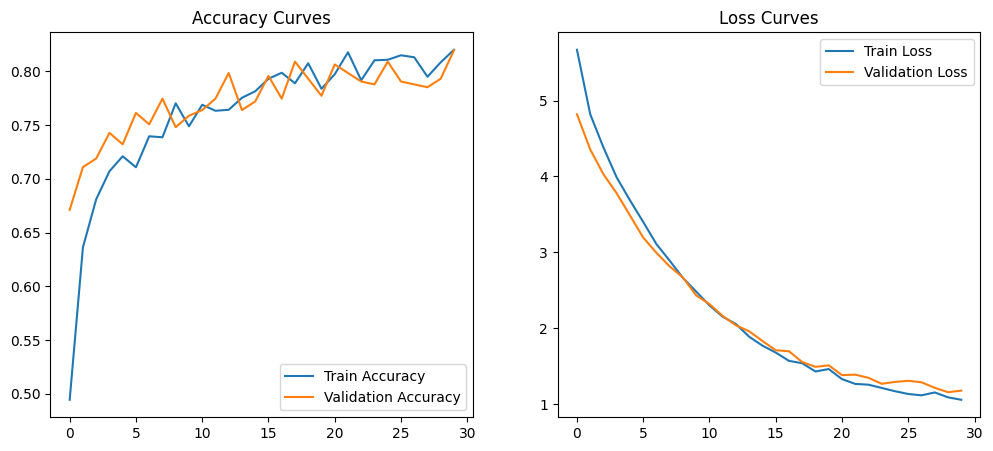

Final Training Accuracy: 0.8200
Final Validation Accuracy: 0.8196


In [ ]:
import matplotlib.pyplot as plt

# Extract training metrics

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

# Print final metrics
print(f"Final Training Accuracy: {train_acc[-1]:.4f}")
print(f"Final Validation Accuracy: {val_acc[-1]:.4f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 893ms/step
              precision    recall  f1-score   support

   cardboard       0.14      0.15      0.15        60
       glass       0.23      0.20      0.21        75
       metal       0.16      0.18      0.17        61
       paper       0.22      0.18      0.20        89
     plastic       0.22      0.24      0.23        72
       trash       0.03      0.05      0.04        20

    accuracy                           0.18       377
   macro avg       0.17      0.17      0.17       377
weighted avg       0.19      0.18      0.19       377



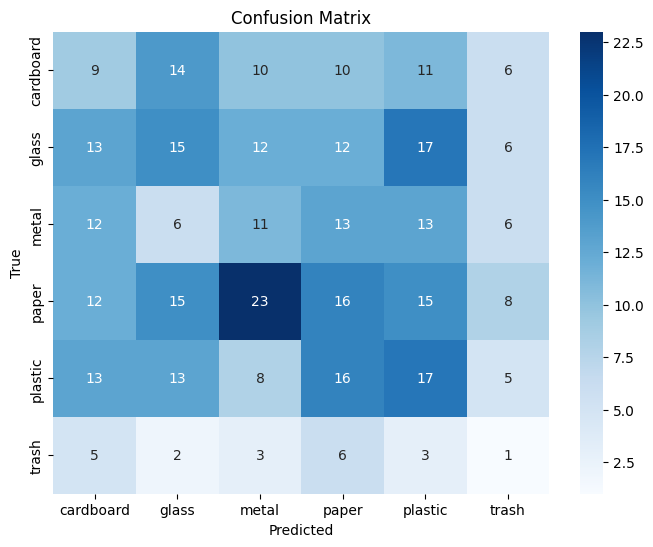

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get true labels and predictions
val_generator.reset()
Y_true = val_generator.classes
Y_pred = model.predict(val_generator)
Y_pred_classes = np.argmax(Y_pred, axis=1)
class_labels = list(val_generator.class_indices.keys())

# Classification report
print(classification_report(Y_true, Y_pred_classes, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(Y_true, Y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [4]:
!pip install streamlit pyngrok


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 100.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 114.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.8 MB/s eta 0:00:00


In [5]:
from pyngrok import ngrok
ngrok.set_auth_token("ENTER THE AUTHENTICATION TOKEN")


In [13]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import numpy as np
from PIL import Image

# 1. Load your trained model (use raw string for Windows path)
@st.cache_resource
def load_model():
    return tf.keras.models.load_model(r'/content/drive/My Drive/waste_classifier_best_train_val.keras')

model = load_model()

# 2. Define your class names
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

st.title('Waste Classification App')
st.write('Upload an image of waste (cardboard, glass, metal, paper, plastic, trash) and get a prediction!')

# 3. File uploader (no folder path here)
uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    img = Image.open(uploaded_file).convert('RGB')
    display_img = img.resize((300, 200))  # Width x Height in pixels

    # Create three columns, put the image in the center one
    col1, col2, col3 = st.columns([1, 2, 1])
    with col2:
        st.image(display_img, caption='Uploaded Image')

    # 4. Preprocess image
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # 5. Prediction
    pred = model.predict(img_array)
    pred_class = class_names[np.argmax(pred)]
    confidence = np.max(pred)

    st.write(f"**Prediction:** {pred_class}")
    st.write(f"**Confidence:** {confidence:.2%}")
else:
    st.info("Please upload an image file.")


Overwriting app.py


In [14]:
!streamlit run app.py &>/content/logs.txt &


In [15]:
public_url = ngrok.connect(8501)
print(public_url)


NgrokTunnel: "https://7ce8-34-34-79-218.ngrok-free.app" -> "http://localhost:8501"
